# Calibration Verifications Using QuTiP.
This notebook aims to provide an intution-building tool into the physical aspect of quantum computing, specifically for superconducting qubits platform.

In [1]:
# Import necessary libraries and constants
import qutip as qt  # Quantum toolbox in Python
from matplotlib import pyplot as plt  # For plotting
from joblib import Parallel, delayed  # For parallel processing
import scqubits as scq  # For superconducting qubits simulations
import numpy as np  # For numerical operations
from tqdm import tqdm  # For progress bars
import pickle  # For saving and loading data
v_Mhz = 2*np.pi*1e6  # Conversion factor for MHz to angular frequency

## Resonator Spectroscopy
This subsection focuses on resonator spectroscopy, where we sweep the probe frequency to find resonator resonance.

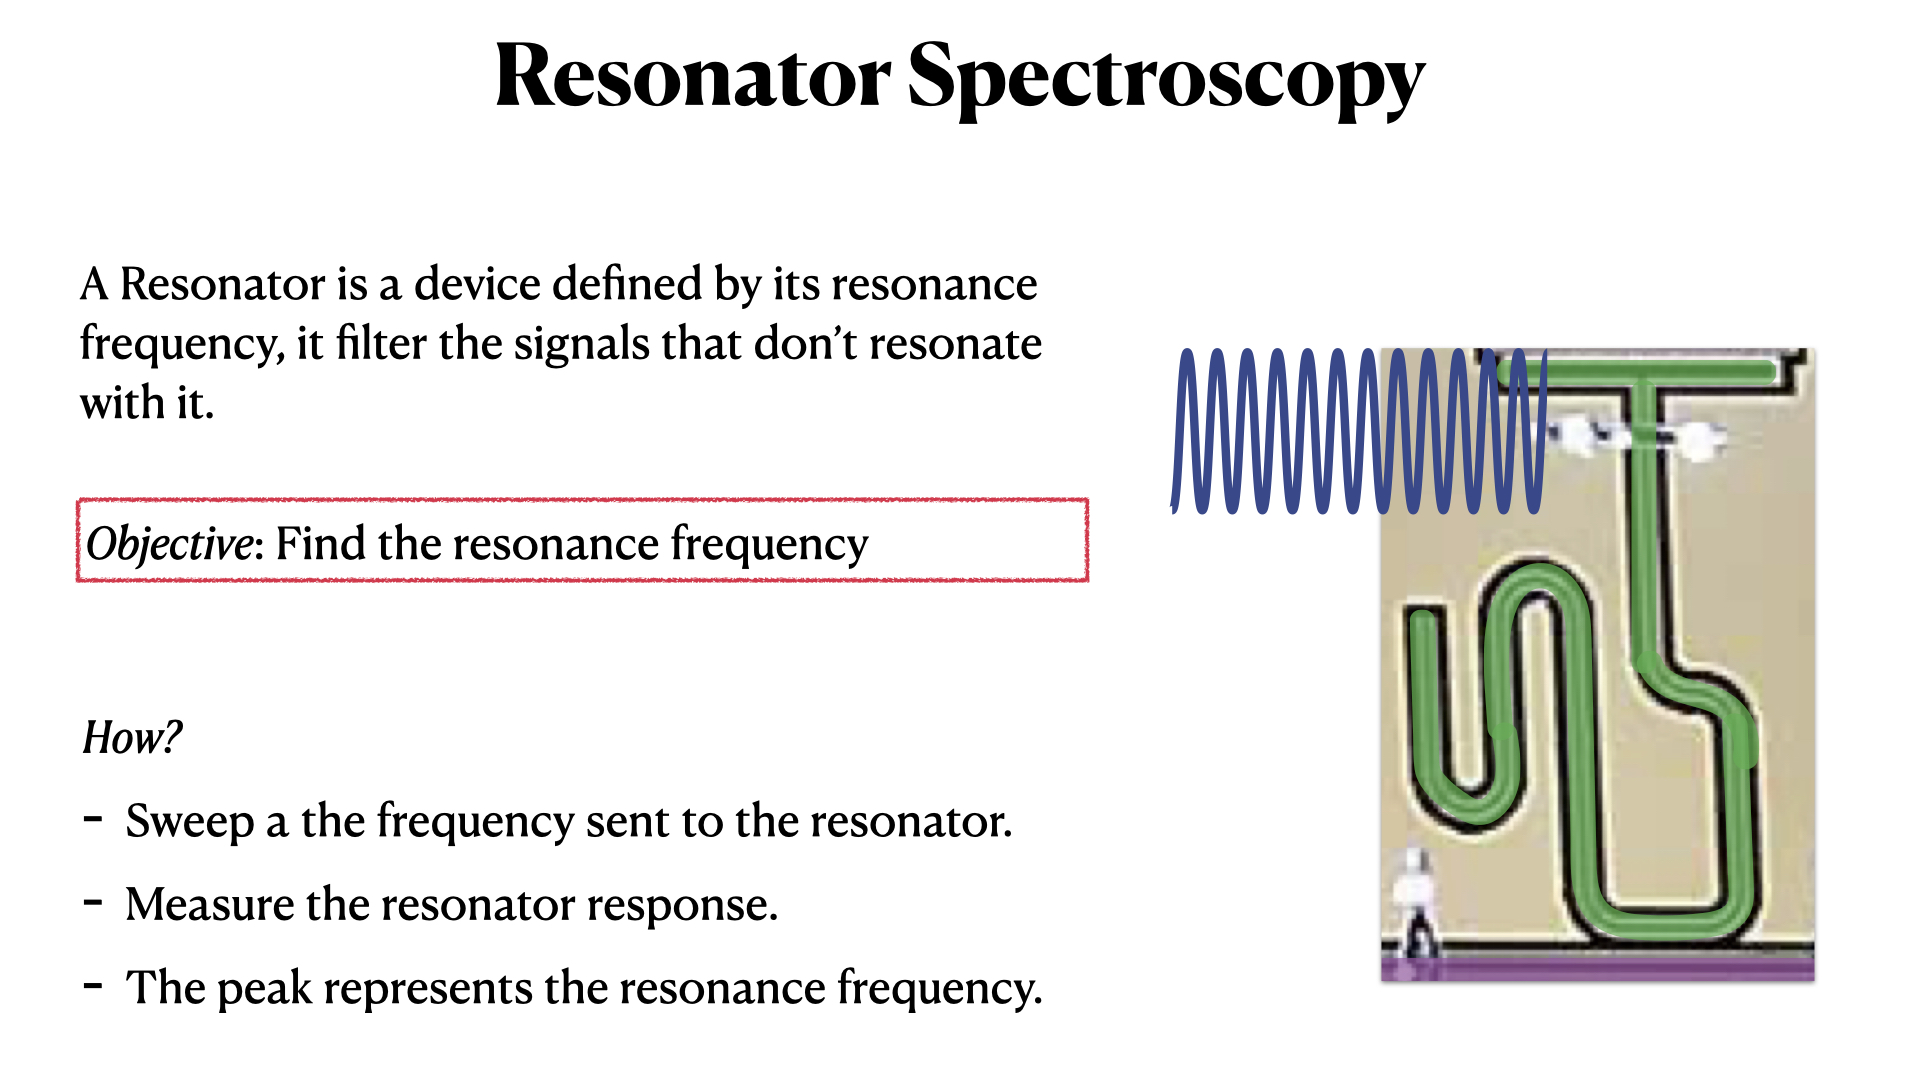

In [2]:
# Define a cosine envelope function for pulse shaping
def cosine_envelope(t, t0, plateau, width):
    omega_ramp = 2 * np.pi / (4 * width) if width != 0 else 0
    return (
        (t0 + width < t < t0 + plateau + width)
        + (t0 <= t <= t0 + width) * (-np.cos(omega_ramp * (t - t0)) ** 2 + 1)
        + (t0 + plateau + width <= t <= t0 + plateau + 2 * width)
        * (-np.cos(omega_ramp * (t - (t0 + plateau + 2 * width))) ** 2 + 1)
    )

In [3]:
# Define system parameters and construct Hamiltonian

# Number of energy levels for qubit and resonator
q_levels = 5  # Qubit levels
r_levels = 5  # Resonator levels

# Define annihilation operators for qubit and resonator
r_op = qt.tensor(qt.qeye(q_levels), qt.destroy(r_levels)).to("CSR")  # Resonator operator
q_op = qt.tensor(qt.destroy(q_levels), qt.qeye(r_levels)).to("CSR")  # Qubit operator

# Define qubit and resonator frequencies
q_freq = 5.5 * 1e3 * v_Mhz  # Qubit frequency in angular MHz
r_freq = 6.5 * 1e3 * v_Mhz  # Resonator frequency in angular MHz

# Define qubit parameters: charging energy (EC) and Josephson energy (EJ)
EC = 275 * v_Mhz  # Charging energy
EJ = (q_freq + EC) ** 2 / 8 / EC  # Josephson energy derived from qubit frequency

# Create qubit and resonator Hamiltonians using scqubits
H_Q = scq.Transmon(EC=EC, EJ=EJ, ng=0.0, ncut=100, truncated_dim=q_levels)  # Qubit Hamiltonian
H_R = scq.Oscillator(E_osc=r_freq, truncated_dim=r_levels)  # Resonator Hamiltonian

# Combine qubit and resonator into a single Hilbert space
H_QR = scq.HilbertSpace([H_Q, H_R])

# Define coupling strength between qubit and resonator
g = 100 * v_Mhz  # Coupling strength in angular MHz

# Add interaction term to the Hamiltonian
H_QR.add_interaction(qobj=-g * (r_op.dag() @ q_op + r_op @ q_op.dag()))

# Convert the full Hamiltonian to a sparse matrix format
H_QR = H_QR.hamiltonian().to("CSR")

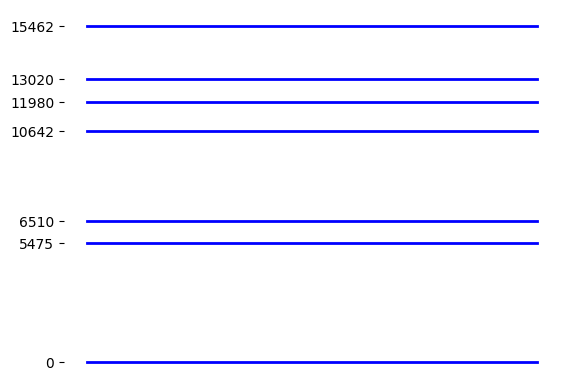

In [4]:
# Plot energy levels of the system
qt.plot_energy_levels([(qt.Qobj(np.diag(H_QR.eigenenergies()))-qt.Qobj(np.diag(H_QR.eigenenergies())).eigenenergies()[0])/v_Mhz], N=7)
plt.show()

In [5]:
# Extract qubit and resonator frequencies from eigenenergies
q_freq = H_QR.eigenenergies()[1]-H_QR.eigenenergies()[0]
r_freq = H_QR.eigenenergies()[2]-H_QR.eigenenergies()[0]

In [6]:
# Define parameters for resonator spectroscopy

# Frequency sweep range for probing the resonator
freq_sweep = np.linspace(r_freq - 50*v_Mhz, r_freq + 50*v_Mhz, 51)  # Sweep range in angular MHz

# Pulse shaping parameters
plateau = 50e-9  # Duration of the flat part of the pulse (seconds)
width = 10e-9  # Duration of the rising/falling edges (seconds)

# Time list for the pulse
tlist = np.arange(0, plateau + 2*width, 1e-9)  # Time steps in nanoseconds

# Drive amplitude for the resonator
amp = 5 * v_Mhz  # Drive amplitude in angular MHz

# Define the resonator drive Hamiltonian as a time-dependent operator
H_r_drive = lambda omega_drive: [
    amp * (r_op + r_op.dag()),  # Drive term
    lambda t: np.cos(omega_drive * t) * cosine_envelope(t, 0, plateau, width)  # Time dependence
]

# Define the initial state of the system (ground state)
rho_g = qt.tensor(qt.basis(q_levels, 0), qt.basis(r_levels, 0))  # Ground state of qubit and resonator

In [7]:
# # Perform resonator spectroscopy simulation
# output_r_spectroscopy = np.array(list(
#     tqdm(
#         Parallel(n_jobs=-1, return_as="generator")(
#             delayed(qt.mesolve)(
#                 [H_QR,H_r_drive(omega_drive)]
#                 ,
#                 rho_g,
#                 tlist,
#                 c_ops=[],
#                 e_ops=[r_op.dag()@r_op],
#             )
#             for omega_drive in freq_sweep
#         ),
#         total=len(freq_sweep),
#     ))).reshape(len(freq_sweep))

# r_N_photons = [output_r_spectroscopy[k].expect[0][-1] for k in range(len(freq_sweep))]


In [8]:
# # pickle the output data for later use
# with open('sim_data/output_r_spectroscopy.pkl', 'wb') as f:
#     pickle.dump(output_r_spectroscopy, f)

In [9]:
# import simulated data from pickle file
with open('sim_data/output_r_spectroscopy.pkl', 'rb') as f:
    output_r_spectroscopy = pickle.load(f)
r_N_photons = [output_r_spectroscopy[k].expect[0][-1] for k in range(len(freq_sweep))]


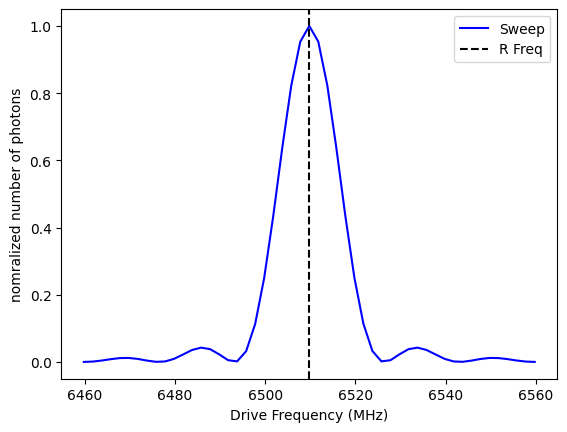

In [10]:
# Plot normalized photon number vs drive frequency
plt.plot(freq_sweep/v_Mhz, r_N_photons/np.max(r_N_photons), 'b', label = r'Sweep')
plt.axvline(r_freq/v_Mhz, c='k', linestyle = '--', label = 'R Freq')
plt.xlabel('Drive Frequency (MHz)')
plt.ylabel('nomralized number of photons')
plt.legend()
plt.show()

## Two-Tone
Here, we perform a two-tone spectroscopy to find the qubit frequency.

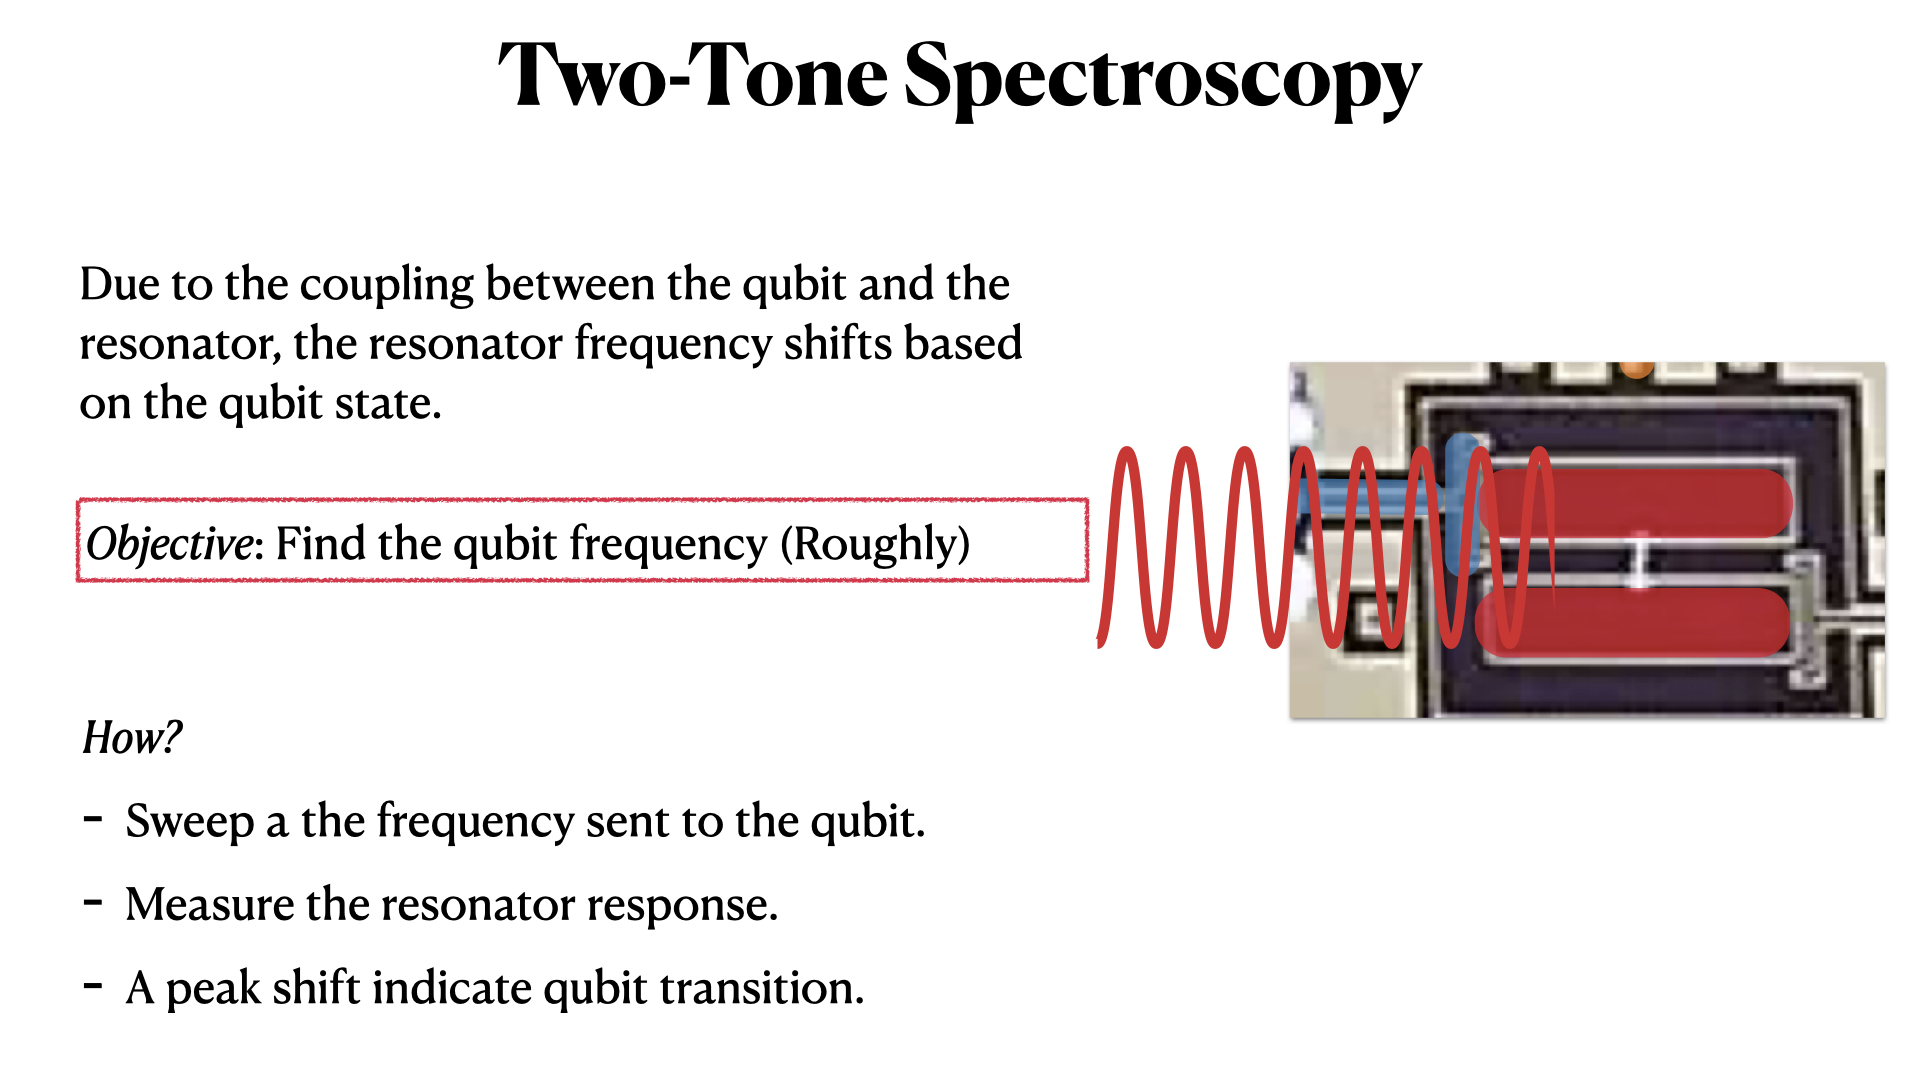

In [11]:
# Define parameters for two-tone spectroscopy

# Frequency sweeps for resonator and qubit drives
freq_sweep = np.linspace(r_freq - 30*v_Mhz, r_freq + 30*v_Mhz, 51)  # Resonator frequency sweep
ctrl_sweep = np.linspace(q_freq - 50*v_Mhz, q_freq + 50*v_Mhz, 36)  # Qubit frequency sweep

# Pulse shaping parameters
plateau = 50e-9  # Duration of the flat part of the pulse (seconds)
width = 10e-9  # Duration of the rising/falling edges (seconds)

# Time list for the pulse
tlist = np.arange(0, 2 * (plateau + 2*width), 1e-9)  # Time steps in nanoseconds

# Drive amplitude for the qubit and resonator
amp = 5 * v_Mhz  # Drive amplitude in angular MHz

# Define the resonator and qubit drive Hamiltonians as time-dependent operators
H_r_drive = lambda omega_drive: [
    amp * (r_op + r_op.dag()),  # Resonator drive term
    lambda t: np.cos(omega_drive * t) * cosine_envelope(t, (plateau + 2*width), plateau, width)  # Time dependence
]
H_q_drive = lambda omega_drive: [
    amp * (q_op + q_op.dag()),  # Qubit drive term
    lambda t: np.cos(omega_drive * t) * cosine_envelope(t, 0, plateau, width)  # Time dependence
]

# Define the initial states of the system
rho_g = qt.tensor(qt.basis(q_levels, 0), qt.basis(r_levels, 0))  # Ground state
rho_e = qt.tensor(qt.basis(q_levels, 1), qt.basis(r_levels, 0))  # Excited state of the qubit

In [12]:
# # Perform two-tone spectroscopy simulation
# output_two_tone = np.array(list(
#     tqdm(
#         Parallel(n_jobs=-1, return_as="generator")(
#             delayed(qt.mesolve)(
#                 [H_QR,H_r_drive(omega_r_drive), H_q_drive(omega_q_drive)]
#                 ,
#                 rho_g,
#                 tlist,
#                 c_ops=[],
#                 e_ops=[r_op.dag()@r_op],
#             )
#             for omega_q_drive in ctrl_sweep
#             for omega_r_drive in freq_sweep
#         ),
#         total=len(ctrl_sweep)*len(freq_sweep),
#     ))).reshape(len(ctrl_sweep), len(freq_sweep))
# n_photons_all = np.array([output_two_tone[c,r].expect[0][-1] for c in range(len(ctrl_sweep)) for r in range(len(freq_sweep))]).reshape(len(ctrl_sweep), len(freq_sweep))

In [13]:
# Pickle the output data for later use
# with open('sim_data/output_two_tone.pkl', 'wb') as f:
#     pickle.dump(output_two_tone, f)

In [14]:
# Import simulated data from pickle file
with open('sim_data/output_two_tone.pkl', 'rb') as f:
    output_two_tone = pickle.load(f)
n_photons_all = np.array([output_two_tone[c,r].expect[0][-1] for c in range(len(ctrl_sweep)) for r in range(len(freq_sweep))]).reshape(len(ctrl_sweep), len(freq_sweep))

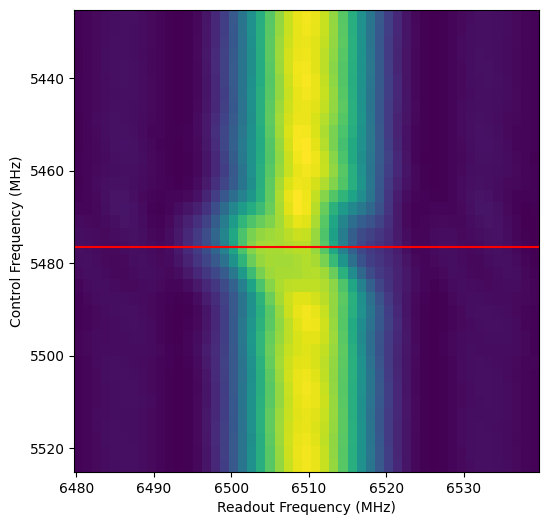

In [15]:
# Plot two-tone spectroscopy results
fig, ax = plt.subplots(figsize=(6,6))

plt.imshow(n_photons_all, extent=[freq_sweep.min()/v_Mhz,freq_sweep.max()/v_Mhz,ctrl_sweep.max()/v_Mhz,ctrl_sweep.min()/v_Mhz], aspect='auto')
plt.axhline(ctrl_sweep[18]/v_Mhz, c='r')
plt.xlabel('Readout Frequency (MHz)')
plt.ylabel('Control Frequency (MHz)')

plt.show()

## Rabi Measurement
In this section, we measure the Rabi oscillations of the qubit. The resonator is removed to simplify the system and focus solely on the qubit dynamics. The system size is reduced to 3 levels to improve computational efficiency while retaining sufficient accuracy for the qubit's behavior.

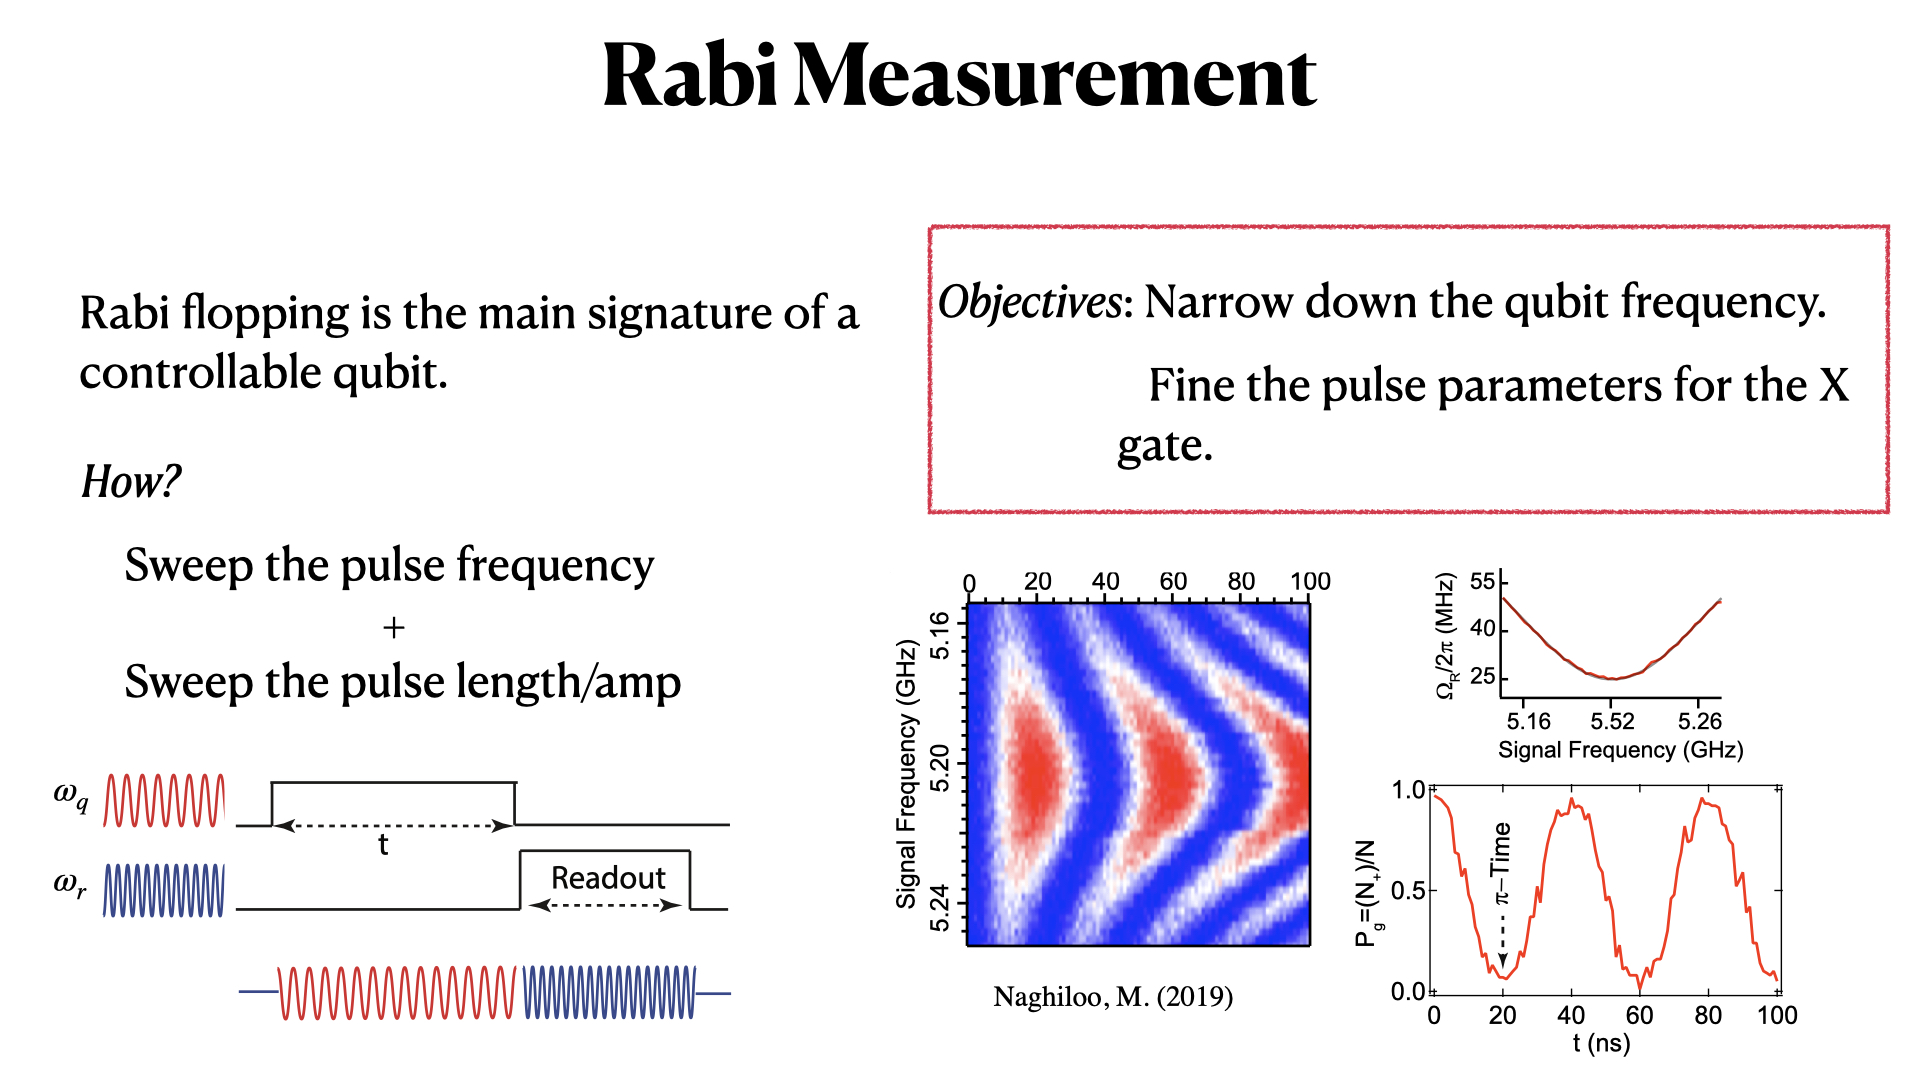

In [16]:
# Define functions for Rabi oscillation fitting and plotting
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def rabi_oscillation(t, omega1, Omega):
    """Rabi oscillation model: P = (omega1^2/Omega^2) * sin^2(Omega*t/2)"""
    return (omega1**2 / Omega**2) * np.sin(Omega * t / 2)**2

def fit_rabi_oscillation(times, probabilities):
    """
    Fit Rabi oscillation data and return parameters with uncertainties
    
    Parameters:
    -----------
    times : array-like
        Time points (typically in μs)
    probabilities : array-like
        Measured excitation probabilities
        
    Returns:
    --------
    dict
        Contains fit parameters, uncertainties, and the fitted curve
    """
    # Initial parameter guesses
    # Estimate Omega from the data by looking at oscillation period
    idx_peaks = np.argwhere(np.diff(np.sign(np.diff(probabilities))) < 0).flatten() + 1
    if len(idx_peaks) >= 2:
        T_estimated = (times[idx_peaks[-1]] - times[idx_peaks[0]]) / (len(idx_peaks) - 1)
        Omega_guess = 2 * np.pi / T_estimated
    else:
        # Fallback if peaks detection fails
        Omega_guess = 2 * np.pi / (times[-1] - times[0]) * 2
    
    omega1_guess = np.sqrt(np.max(probabilities)) * Omega_guess
    
    # Bounds for parameters (lower, upper)
    bounds = ([0, 0], [np.inf, np.inf])
    
    try:
        # Perform the fit with robust error handling
        popt, pcov = curve_fit(
            rabi_oscillation, 
            times, 
            probabilities, 
            p0=[omega1_guess, Omega_guess],
            bounds=bounds,
            maxfev=10000,  # Increase max iterations
            method='trf'   # Trust Region Reflective algorithm (robust)
        )
        
        # Extract parameters and uncertainties
        omega1_fit, Omega_fit = popt
        omega1_err, Omega_err = np.sqrt(np.diag(pcov))
        
        # Generate fitted curve on a finer grid for plotting
        t_fine = np.linspace(min(times), max(times), 1000)
        p_fit = rabi_oscillation(t_fine, omega1_fit, Omega_fit)
        
        return {
            'omega1': omega1_fit,
            'Omega': Omega_fit,
            'omega1_err': omega1_err,
            'Omega_err': Omega_err,
            't_fit': t_fine,
            'p_fit': p_fit,
            'rabi_period': 2*np.pi/Omega_fit,
            'max_probability': (omega1_fit/Omega_fit)**2
        }
        
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None

def plot_rabi_fit(times, probabilities, fit_results):
    """Plot the original data and the fit"""
    plt.figure(figsize=(10, 6))
    plt.scatter(times, probabilities, label='Data', color='blue')
    
    if fit_results:
        plt.plot(fit_results['t_fit'], fit_results['p_fit'], 'r-', label='Fit')
        plt.title(f"Rabi Oscillation Fit\nΩ = {fit_results['Omega']:.3f} ± {fit_results['Omega_err']:.3f}\n"
                 f"ω₁ = {fit_results['omega1']:.3f} ± {fit_results['omega1_err']:.3f}\n"
                 f"Rabi Period = {fit_results['rabi_period']:.3f}")
    
    plt.xlabel('Time')
    plt.ylabel('Excitation Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Define function to extract T1 from simulation results
from scipy.optimize import curve_fit
exponential_decay = lambda t, A, T1, c: A * np.exp(-1 * t / T1) + c

def get_t1(e_pop, delay_sweep):

    initial_guess = [1, 35, 3]  # Initial parameter guess for the fit
    popt, pcov = curve_fit(
        exponential_decay,
        delay_sweep,
        e_pop,
        p0=initial_guess,
    )
    t1 = popt[1]
    return t1, popt, pcov


In [17]:
# Define functions for Ramsey oscillation fitting
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def fit_ramsey_oscillation(delays, populations, plot=True, verbose=True):
    """
    Fit Ramsey oscillation data to extract T2* and detuning frequency.
    
    Parameters:
    -----------
    delays : array-like
        Delay times in seconds or microseconds
    populations : array-like
        Measured excited state populations
    plot : bool, optional
        Whether to plot the results
    verbose : bool, optional
        Whether to print the fit results
        
    Returns:
    --------
    dict
        Contains fit parameters, uncertainties, and the fitted curve
    """
    import matplotlib.pyplot as plt
    
    # Define the Ramsey decay model: A*cos(omega*t + phi)*exp(-t/T2) + C
    def ramsey_model(t, A, omega, phi, T2, C):
        return A * np.sin(omega * t + phi) * np.exp(-t / T2) + C
    
    # Initial parameter guesses
    # Try to estimate frequency from peaks in the data
    peaks, _ = find_peaks(populations)
    
    if len(peaks) >= 2:
        # Estimate frequency from peak spacing
        avg_peak_spacing = np.mean(np.diff(delays[peaks]))
        omega_guess = 2 * np.pi / avg_peak_spacing
    else:
        # Fallback if peak detection fails
        omega_guess = 2 * np.pi / (delays[-1] - delays[0]) * 2
    
    A_guess = (np.max(populations) - np.min(populations)) / 2
    C_guess = np.mean(populations)
    T2_guess = (delays[-1] - delays[0]) / 3  # Initial guess for T2*
    phi_guess = 0  # Initial phase guess
    
    # Perform the fit
    try:
        popt, pcov = curve_fit(
            ramsey_model, 
            delays, 
            populations, 
            p0=[A_guess, omega_guess, phi_guess, T2_guess, C_guess],
            bounds=([0, 0, -np.pi, 0, 0], 
                    [np.inf, np.inf, np.pi, np.inf, np.inf]),
            maxfev=10000
        )
        
        A_fit, omega_fit, phi_fit, T2_fit, C_fit = popt
        perr = np.sqrt(np.diag(pcov))
        
        # Generate fitted curve for plotting
        dense_delays = np.linspace(delays.min(), delays.max(), 1000)
        fit_curve = ramsey_model(dense_delays, *popt)
        
        # Convert to more intuitive units if delays are in seconds
        T2_unit = "μs"
        freq_unit = "MHz"
        
        # Check if we should use μs instead
        avg_delay = np.mean(delays)
        T2_fit_display = T2_fit
        T2_err_display = perr[3]
        freq_display = omega_fit / (2 * np.pi)
        freq_err_display = perr[1] / (2 * np.pi)
        
        if verbose:
            print(f"Fit results:")
            print(f"T2* = {T2_fit_display:.3f} ± {T2_err_display:.3f} {T2_unit}")
            # print(f"Detuning = {freq_display:.3f} ± {freq_err_display:.3f} {freq_unit}")
            # print(f"Amplitude = {A_fit:.3f} ± {perr[0]:.3f}")
            # print(f"Phase = {phi_fit:.3f} ± {perr[2]:.3f} rad")
            # print(f"Offset = {C_fit:.3f} ± {perr[4]:.3f}")
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(delays, populations, 'bo', label='Data')
            plt.plot(dense_delays, fit_curve, 'r-', label='Fit')
            plt.xlabel(f'Delay ({T2_unit})')
            plt.ylabel('Excited state population')
            plt.title(f'Ramsey Oscillation: T2* = {T2_fit_display:.3f} {T2_unit}')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()
        
        return {
            "T2": T2_fit,
            "T2_err": perr[3],
            "detuning": omega_fit / (2 * np.pi),
            "detuning_err": perr[1] / (2 * np.pi),
            "amplitude": A_fit,
            "amplitude_err": perr[0],
            "phase": phi_fit,
            "phase_err": perr[2],
            "offset": C_fit,
            "offset_err": perr[4],
            "delays": dense_delays,
            "fit": fit_curve,
            "units": {"time": T2_unit, "frequency": freq_unit}
        }
        
    except Exception as e:
        print(f"Fitting error: {e}")
        return None

In [18]:
# Define parameters for Rabi measurement

# Number of energy levels for the qubit
q_levels = 3  # Reduced to 3 levels for computational efficiency

# Define annihilation operator for the qubit
q_op = qt.destroy(q_levels).to("CSR")  # Qubit operator

# Define qubit frequency and parameters
q_freq = 5.5 * 1e3 * v_Mhz  # Qubit frequency in angular MHz
EC = 275 * v_Mhz  # Charging energy
EJ = (q_freq + EC) ** 2 / 8 / EC  # Josephson energy derived from qubit frequency

# Create the qubit Hamiltonian
H_Q = scq.Transmon(EC=EC, EJ=EJ, ng=0.0, ncut=100, truncated_dim=q_levels)
H_0 = scq.HilbertSpace([H_Q]).hamiltonian().to('CSR')  # Qubit Hamiltonian

# Actual qubit frequency after diagonalization
q_freq = H_0.eigenenergies()[1] - H_0.eigenenergies()[0]  # Qubit frequency in angular MHz

# Define the initial states of the qubit
rho_g = qt.basis(q_levels, 0)  # Ground state
rho_e = qt.basis(q_levels, 1)  # Excited state

In [19]:
# Define sweep parameters for Rabi measurement
ctrl_sweep = np.linspace(q_freq - 10*v_Mhz, q_freq+10*v_Mhz, 32)
plateau_sweep = np.linspace(0,250e-9, 36)

plateau = 30e-9
width = 10e-9

tlist = lambda plateau: np.arange(0,plateau + 2*width, 1e-9)

amp = 10*v_Mhz

H_q_drive = lambda omega_drive, plateau : [amp * (q_op + q_op.dag()), lambda t: np.cos(omega_drive * t) * cosine_envelope(t, 0, plateau, width)]

In [20]:
# Perform Rabi measurement simulation
# output_chevron = np.array(list(
#     tqdm(
#         Parallel(n_jobs=-1, return_as="generator")(
#             delayed(qt.mesolve)(
#                 [H_0, H_q_drive(omega_q_drive, plateau)]
#                 ,
#                 rho_g,
#                 tlist(plateau),
#                 c_ops=[],
#                 e_ops=[rho_g.proj()],
#             )
#             for omega_q_drive in ctrl_sweep
#             for plateau in plateau_sweep
#         ),
#         total=len(ctrl_sweep)*len(plateau_sweep),
#     ))).reshape(len(ctrl_sweep), len(plateau_sweep))

# n_photons_chevron = np.array([output_chevron[c,a].expect[0][-1] for c in range(len(ctrl_sweep)) for a in range(len(plateau_sweep))]).reshape(len(ctrl_sweep), len(plateau_sweep))

In [21]:
# # pickle the output data for later use
# with open('sim_data/output_chevron.pkl', 'wb') as f:
#     pickle.dump(output_chevron, f)

In [22]:
# import simulated data from pickle file
with open('sim_data/output_chevron.pkl', 'rb') as f:
    output_chevron = pickle.load(f)
n_photons_chevron = np.array([output_chevron[c,a].expect[0][-1] for c in range(len(ctrl_sweep)) for a in range(len(plateau_sweep))]).reshape(len(ctrl_sweep), len(plateau_sweep))

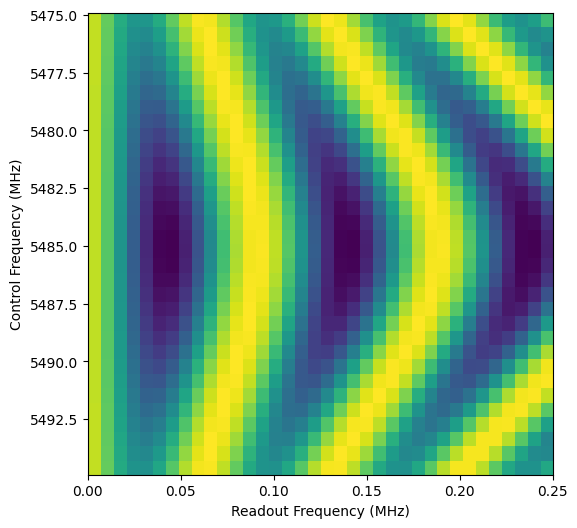

In [23]:
# Plot Rabi measurement results
fig, ax = plt.subplots(figsize=(6,6))

plt.imshow(n_photons_chevron, extent=[plateau_sweep.min()*1e6,plateau_sweep.max()*1e6,ctrl_sweep.max()/v_Mhz,ctrl_sweep.min()/v_Mhz], aspect='auto')
plt.xlabel('Readout Frequency (MHz)')
plt.ylabel('Control Frequency (MHz)')

plt.show()

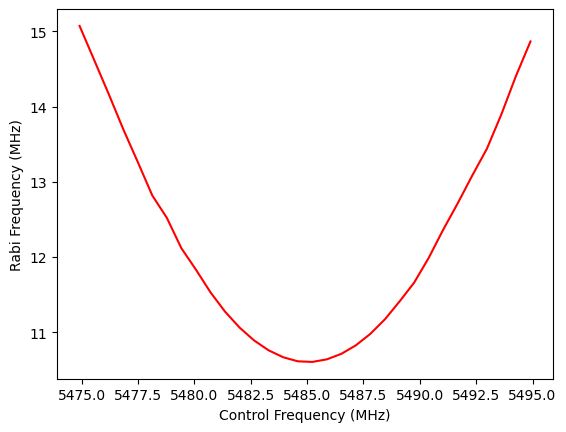

In [24]:
# Plot Rabi frequency vs control frequency
plt.plot(ctrl_sweep/v_Mhz, [fit_rabi_oscillation(plateau_sweep, 1-n_photons_chevron[k])['Omega']/v_Mhz for k in range(len(ctrl_sweep))], '-r')
plt.xlabel('Control Frequency (MHz)')
plt.ylabel('Rabi Frequency (MHz)')

best_control_index = np.argmin([fit_rabi_oscillation(plateau_sweep, 1-n_photons_chevron[k])['Omega'] for k in range(len(ctrl_sweep))])

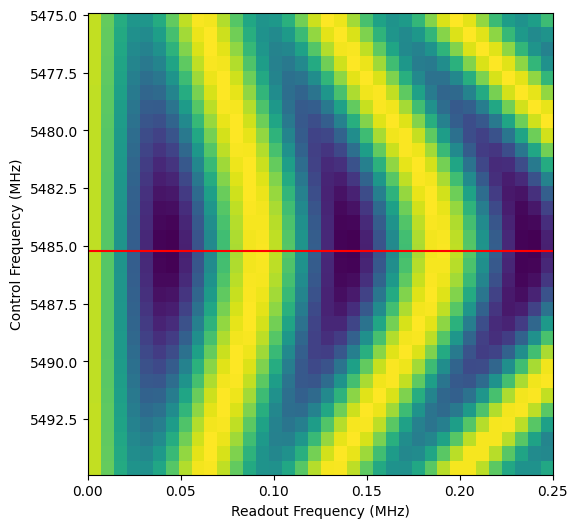

In [25]:
# Highlight best control frequency in Rabi measurement plot
fig, ax = plt.subplots(figsize=(6,6))

plt.imshow(n_photons_chevron, extent=[plateau_sweep.min()*1e6,plateau_sweep.max()*1e6,ctrl_sweep.max()/v_Mhz,ctrl_sweep.min()/v_Mhz], aspect='auto')
plt.axhline(ctrl_sweep[best_control_index]/v_Mhz, c='r')
plt.xlabel('Readout Frequency (MHz)')
plt.ylabel('Control Frequency (MHz)')

plt.show()

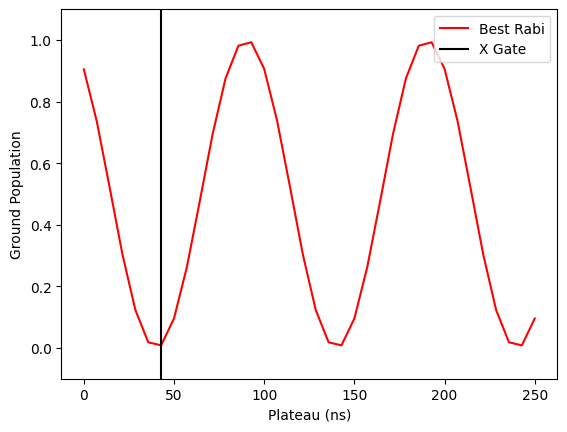

In [26]:
# Plot ground population vs plateau duration
plt.plot(plateau_sweep*1e9, n_photons_chevron[best_control_index], 'r', label= 'Best Rabi')
plt.axvline(1e9*plateau_sweep[n_photons_chevron[best_control_index][:10].argmin()], c='k', label = 'X Gate')
plt.xlabel('Plateau (ns)')
plt.ylabel('Ground Population')
plt.legend()
plt.ylim(-0.1,1.1)
plt.show()


best_plateau_index=n_photons_chevron[best_control_index][:10].argmin()

In [27]:
# Extract optimal parameters for pi pulse
pi_amp = amp
pi_plateau = plateau_sweep[best_plateau_index]
q_actual_freq = ctrl_sweep[best_control_index]

## Qubit Characterization
In this chapter, we characterize the qubit by measuring its relaxation time (T1) and coherence time (T2*).

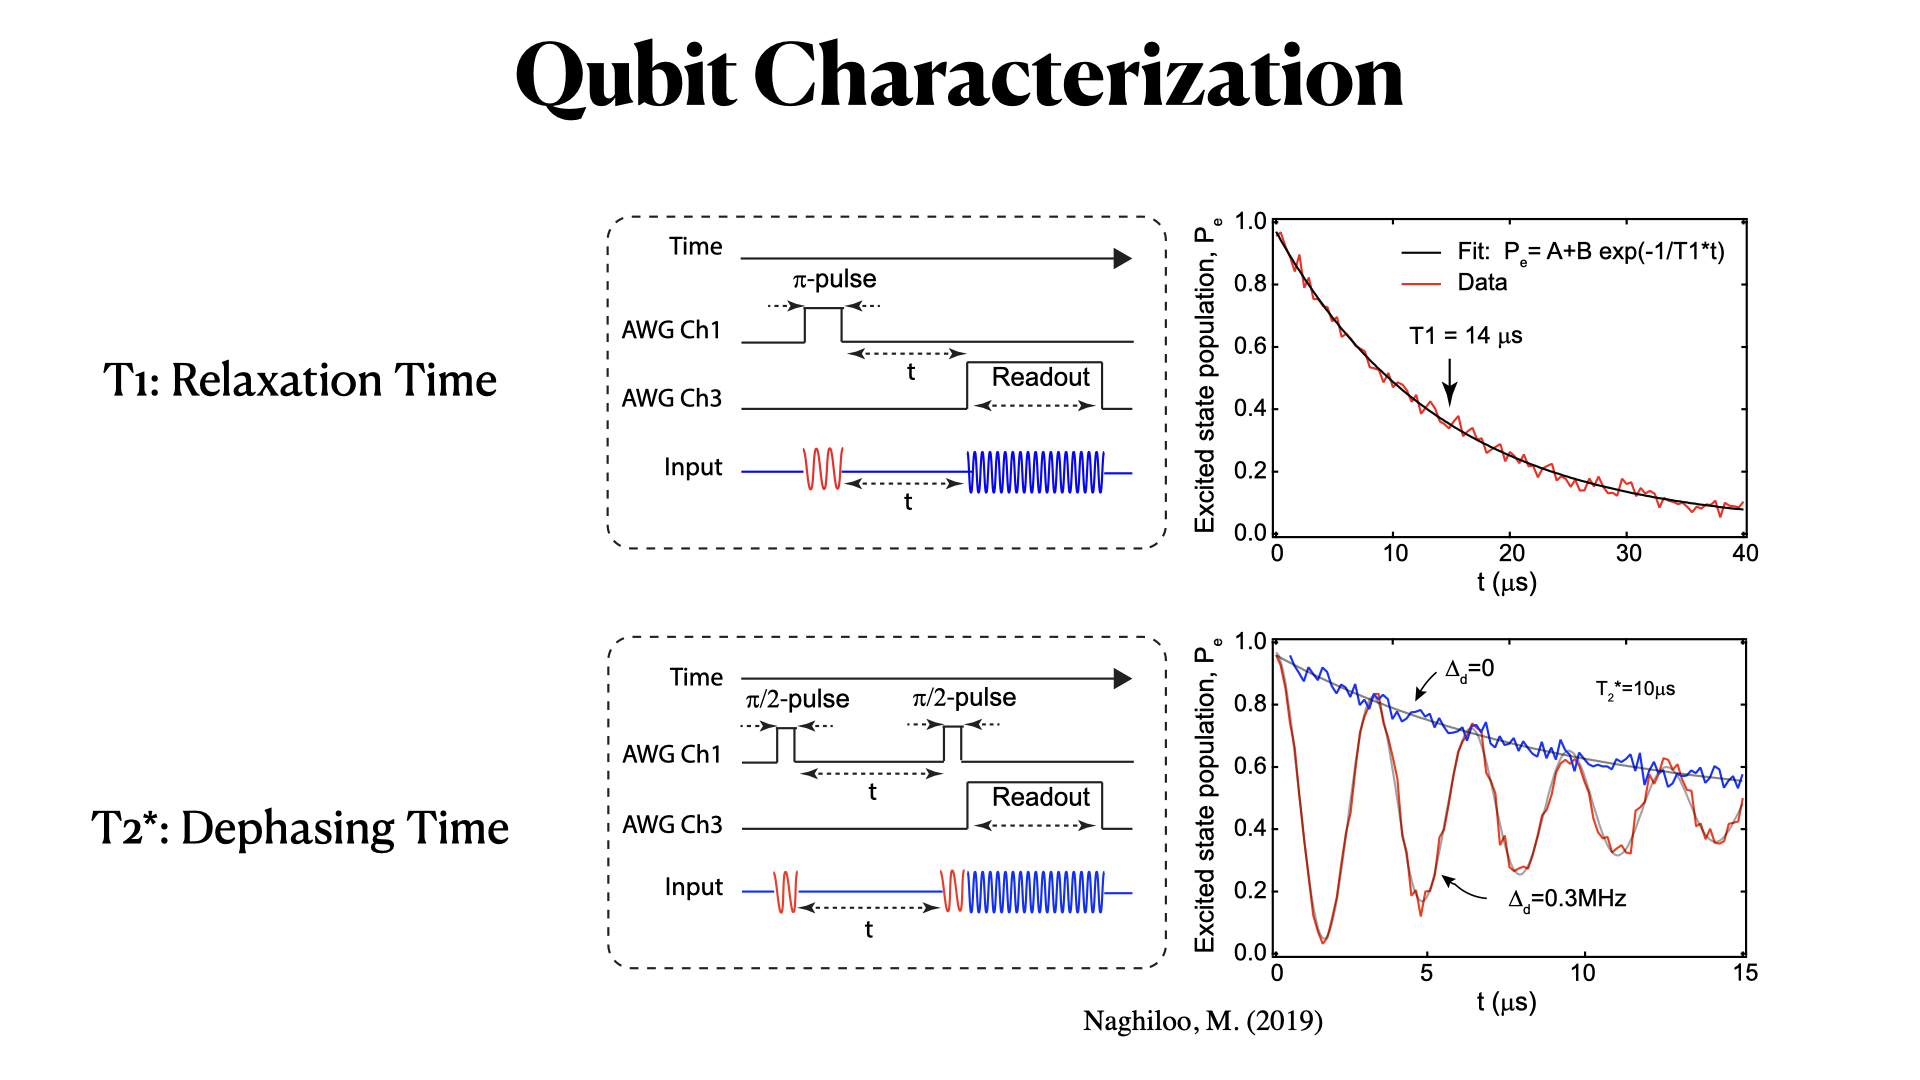

### T1 Measurement
This subsection measures the relaxation time (T1) of the qubit, which represents the time it takes for the qubit to return to its ground state.

In [28]:
# # Define parameters for T1 measurement

# # Number of energy levels for the qubit
# q_levels = 3  # Reduced to 3 levels for computational efficiency

# # Define annihilation operator for the qubit
# q_op = qt.destroy(q_levels).to("CSR")  # Qubit operator

# # Define qubit frequency and parameters
# q_freq = 5.5 * 1e3 * v_Mhz  # Qubit frequency in angular MHz
# EC = 275 * v_Mhz  # Charging energy
# EJ = (q_freq + EC) ** 2 / 8 / EC  # Josephson energy derived from qubit frequency

# # Create the qubit Hamiltonian
# H_Q = scq.Transmon(EC=EC, EJ=EJ, ng=0.0, ncut=100, truncated_dim=q_levels)
# H_0 = scq.HilbertSpace([H_Q]).hamiltonian().to('CSR')  # Qubit Hamiltonian

# # Define the initial states of the qubit
# rho_g = qt.basis(q_levels, 0)  # Ground state
# rho_e = qt.basis(q_levels, 1)  # Excited state

In [29]:
# Define collapse operators for T1 measurement

# Relaxation time (T1) in seconds
T1 = 100e-6  # Relaxation time
delay = 300e-6  # Delay time for T1 measurement

# Collapse operator for relaxation
c_ops = [np.sqrt(1/T1) * q_op]  # Collapse operator for T1 relaxation


In [30]:
# # Perform T1 measurement simulation
# output_T1 = qt.mesolve(
#                 H_0
#                 ,
#                 rho_e,
#                 tlist(delay),
#                 c_ops=c_ops,
#                 e_ops=[rho_e.proj()], options = dict(progress_bar = 'tqdm')
#             )


In [31]:
# # Pickle the output data for later use
# with open('sim_data/output_T1.pkl', 'wb') as f:
#     pickle.dump(output_T1, f)

In [32]:
# import simulated data from pickle file
with open('sim_data/output_T1.pkl', 'rb') as f:
    output_T1 = pickle.load(f)

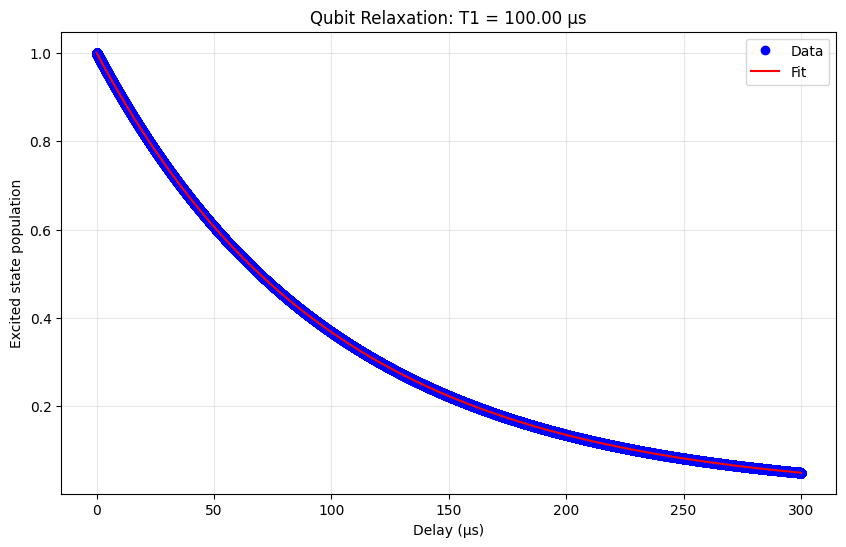

In [33]:
# Plot T1 measurement results
T1_fit, popt, pcov = get_t1(output_T1.expect[0], tlist(delay)*1e6)

T1_fit_curve = exponential_decay(tlist(delay)*1e6, *get_t1(output_T1.expect[0], tlist(delay)*1e6)[1])

plt.figure(figsize=(10, 6))
plt.plot(tlist(delay)*1e6, output_T1.expect[0], 'bo', label='Data')
plt.plot(tlist(delay)*1e6, T1_fit_curve, 'r-', label='Fit')
plt.xlabel(f'Delay (µs)')
plt.ylabel('Excited state population')
plt.title(f'Qubit Relaxation: T1 = {T1_fit:.2f} µs')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### T2* Measurement
Here, we measure the coherence time (T2*) of the qubit, which quantifies the decay of quantum superposition due to dephasing.

In [34]:
# Define parameters for T2* measurement

# Delay times for Ramsey experiment
delay_sweep = np.linspace(0, 10e-6, 32)  # Delay times in seconds

# Coherence time (T2*) in seconds
T2_STAR = 10e-6  # Coherence time

# Drive amplitude for pi pulse
pi_amp = 10 * v_Mhz  # Drive amplitude in angular MHz

# Collapse operator for dephasing
c_ops = [np.sqrt(2/T2_STAR) * q_op.dag() * q_op]  # Collapse operator for T2* dephasing

# Define X gate for Ramsey experiment
X_GATE = lambda pi_amp, omega_drive, t0: [
    pi_amp * (q_op + q_op.dag()),  # Drive term
    lambda t: np.cos(omega_drive * t) * cosine_envelope(t, t0, pi_plateau, width)  # Time dependence
]

In [35]:
# # Perform T2* measurement simulation
# output_T2_star = np.array(list(
#     tqdm(
#         Parallel(n_jobs=-1, return_as="generator")(
#             delayed(qt.mesolve)(
#                 [H_0, X_GATE(pi_amp/2,q_actual_freq+0*v_Mhz,0), X_GATE(pi_amp/2,q_actual_freq+0*v_Mhz,delay)]
#                 ,
#                 rho_g.to('CSR'),
#                 tlist(delay+2*(pi_plateau + 2*width)),
#                 c_ops=c_ops,
#                 e_ops=[rho_e.proj(), (rho_e+rho_g).unit().proj()],
#                 options = dict(store_final_state = True)
#             )
#             for delay in delay_sweep
#         ),
#         total=len(delay_sweep),
#     )))


In [36]:
# # Pickle the output data for later use
# with open('sim_data/output_T2_start.pkl', 'wb') as f:
#     pickle.dump(output_T2_star, f)

In [37]:
# import simulated data from pickle file
with open('sim_data/output_T2_start.pkl', 'rb') as f:
    output_T2_start = pickle.load(f)

Fit results:
T2* = 9.182 ± 0.007 μs


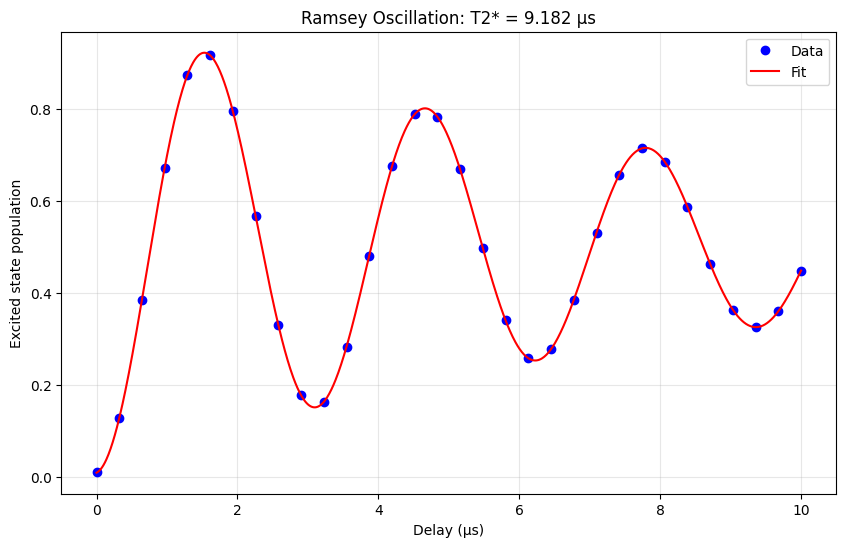

In [38]:
# Fit and plot Ramsey oscillation results
_ = fit_ramsey_oscillation(np.linspace(0,10e-6,32)*1e6, [1-state.expect[0][-1] for state in output_T2_start], plot=True, verbose=True)

**This workshop was presented by UMQ, Join us!**
![UMQ](Ibra_C2Q.048.jpeg)